In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
%cd 'drive/My Drive/MIR'

# import libraries
import os, sys, shutil
from pathlib import Path
import pandas as pd
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import matplotlib.pyplot as plt
import essentia.standard as ess
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')#suppress warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive/
/content/drive/My Drive/MIR
     |████████████████████████████████| 11.7MB 340kB/s 


In [ ]:
#train_file = 'MER_audio_taffc_dataset/train_segments/train_data.csv' 
#test_file = 'MER_audio_taffc_dataset/test_segments/test_data.csv'
#train_file = 'CH-818/train_segments/train_data.csv'
#test_file = 'CH-818/test_segments/test_data.csv' 
train_file = 'tr-music-dataset/train_segments/train_data.csv' 
test_file = 'tr-music-dataset/test_segments/test_data.csv'

train_data1 = pd.read_csv(train_file)
test_data1 = pd.read_csv(test_file)
print(train_data1.shape)

#train_file = 'smile-features/4Q-train-features.csv' 
#test_file = 'smile-features/4Q-test-features.csv'
#train_file = 'smile-features/CH-train-features.csv' 
#test_file = 'smile-features/CH-test-features.csv'
train_file = 'smile-features/TR-train-features.csv' 
test_file = 'smile-features/TR-test-features.csv'    

train_data2 =  pd.read_csv(train_file, sep=',')
test_data2 =  pd.read_csv(test_file, sep=',')
train_data2 = train_data2.drop("frameTime", axis=1)
test_data2 = test_data2.drop("frameTime", axis=1)
print(train_data2.shape)

#combine all files in the list
train_data = pd.concat([train_data1.iloc[:,:84], train_data2], axis=1)
print(train_data.shape)
test_data = pd.concat([test_data1.iloc[:,:84], test_data2], axis=1)
print(test_data.shape)

#export to csv
#train_data.to_csv("4Q-combined-train-features.csv")
#test_data.to_csv("4Q-combined-test-features.csv")

(1280, 85)
(1280, 261)
(1280, 345)
(320, 345)


In [ ]:
train_data_modif = train_data.copy()
test_data_modif = test_data.copy()

min_max_scaler = preprocessing.MinMaxScaler()
train_data_modif.iloc[:,:344] = min_max_scaler.fit_transform(train_data.iloc[:,:344].values)
test_data_modif.iloc[:,:344] = min_max_scaler.fit_transform(test_data.iloc[:,:344].values)

In [ ]:
train_data_modif.emotion.value_counts()

q3    328
q4    328
q1    328
q2    296
Name: emotion, dtype: int64

In [ ]:
# Balancing data   ---> adapt this to the numbers above
data_modif = train_data_modif
min_number = data_modif.emotion.value_counts()['q2']
q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)

#Merging after downsampling
train_data_modif = pd.concat([q1_data, q2_data, q3_data, q4_data])
#Checking the balance again
train_data_modif.emotion.value_counts()

q3    296
q4    296
q2    296
q1    296
Name: emotion, dtype: int64

In [ ]:
# Preparing data arrays for features and labels
#input values put in a matrix, there are 260 features
X_train = train_data_modif.iloc[:,:260].values 
X_test = test_data_modif.iloc[:,:260].values 
#Creating output values
train_data_modif.emotion = pd.Categorical(train_data_modif.emotion)#convert to categorical data
test_data_modif.emotion = pd.Categorical(test_data_modif.emotion)#convert to categorical data
y_train = np.array(train_data_modif.emotion.cat.codes) #create label encoded outputs
y_test = np.array(test_data_modif.emotion.cat.codes) #create label encoded outputs

# Feature selection
z = SelectKBest(chi2, k=50)
fit = z.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
ten = fit.scores_.argsort()[-50:][::-1] # 10 best features selected 

X_train = fit.transform(X_train)
X_test = fit.transform(X_test)   # only consider selected features from the training set
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape, '\n')

print('Top 10 selected features: ')
for i in ten:
    print(train_data_modif.keys()[i])

X_train shape is  (1184, 50)
X_test shape is  (320, 50) 

Top 10 selected features: 
logHNR_sma_stddev
spectral_centroid.mean
spectral_skewness.stdev
spectral_kurtosis.stdev
melbands_spread.mean
barkbands_spread.mean
silence_rate_30dB.stdev
pcm_fftMag_spectralCentroid_sma_amean
barkbands_flatness_db.mean
silence_rate_60dB.stdev
spectral_kurtosis.mean
melbands_flatness_db.mean
zerocrossingrate.mean
pcm_fftMag_spectralRollOff75.0_sma_amean
pcm_fftMag_spectralRollOff90.0_sma_amean
spectral_complexity.stdev
pcm_fftMag_spectralVariance_sma_amean
spectral_complexity.mean
spectral_rolloff.mean
pcm_zcr_sma_amean
erbbands_crest.mean
pcm_fftMag_psySharpness_sma_amean
audspec_lengthL1norm_sma_de_stddev
spectral_skewness.mean
pcm_fftMag_spectralRollOff50.0_sma_amean
erbbands_flatness_db.mean
logHNR_sma_de_stddev
F0final_sma_stddev
spectral_flux.mean
silence_rate_60dB.mean
spectral_entropy.stdev
spectral_energyband_high.mean
F0final_sma_amean
dissonance.stdev
erbbands_kurtosis.mean
spectral_energyb

Number of test samples:  288
              precision    recall  f1-score   support

           0       0.21      0.21      0.21        52
           1       0.14      0.15      0.15        72
           2       0.28      0.29      0.28        92
           3       0.08      0.07      0.07        72

    accuracy                           0.19       288
   macro avg       0.18      0.18      0.18       288
weighted avg       0.18      0.19      0.18       288

Confusion matrix: 



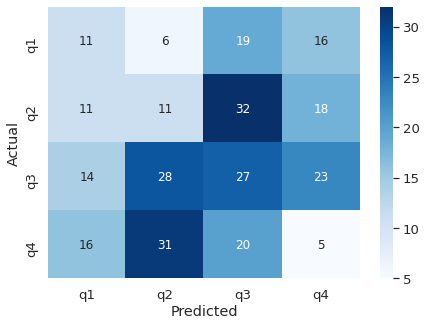

In [ ]:
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");